<a href="https://colab.research.google.com/github/LucasSLDantas/Rede_para_recomendacao_de_produtos/blob/main/Rede_para_recomendacao_de_produtos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Célula 1: Instalar dependências ===
# Execute este comando em uma célula do Colab
!pip install --quiet tensorflow numpy scikit-learn matplotlib

In [ ]:
# === Célula 2: Montar Google Drive e descompactar dataset ===
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()             # selecione o kaggle.json baixado

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucasdasilvadantas","key":"b7bae4b5371ade0d81e11b8e1a623071"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Célula Colab  ➜  faça login no Kaggle e coloque kaggle.json no /root/.kaggle
!kaggle datasets download -d sunnykusawa/ecommerce-products-image-dataset -p /content

Dataset URL: https://www.kaggle.com/datasets/sunnykusawa/ecommerce-products-image-dataset
License(s): CC0-1.0


In [ ]:
!kaggle datasets download -d gauravduttakiit/product-image-classification -p /content

Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/product-image-classification
License(s): apache-2.0


In [ ]:
!kaggle datasets download -d fatihkgg/ecommerce-product-images-18k -p /content

Dataset URL: https://www.kaggle.com/datasets/fatihkgg/ecommerce-product-images-18k
License(s): apache-2.0


In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT


In [ ]:
!unzip -q /content/product-image-classification.zip -d /content/dataset

In [ ]:
!unzip -q /content/ecommerce-products-image-dataset.zip -d /content/dataset2

In [ ]:
!unzip -q /content/ecommerce-product-images-18k.zip -d /content/dataset3

In [ ]:
!unzip -q /content/fashion-product-images-small.zip -d /content/dataset4

In [ ]:
# Ajuste o caminho abaixo para onde está seu dataset.zip no Drive
#!unzip -q /content/drive/MyDrive/dataset.zip -d /content/dataset

In [ ]:
# === Célula 3: Imports e parâmetros ===
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

# Parâmetros
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [ ]:
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/dataset4/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/dataset4/images')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/dataset4/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:03<00:00, 242.72it/s]

Moved 44441 images.


In [ ]:
#hide
data_dir = '/content/Fashion_data/categories'

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [ ]:
import tf_keras

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf_keras.Sequential([
    tf_keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf_keras.layers.Dropout(rate=0.2),
    tf_keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf_keras.layers.Dropout(rate=0.2),
    tf_keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212748999 (811.57 MB)
Trainable params: 1574919 (6.01 MB)
Non-trainable params: 211174080 (805.57 MB)
_____________

In [ ]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf_keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf_keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf_keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1111/1111 [==============================] - 1323s 1s/step - loss: 0.2707 - accuracy: 0.9702 - val_loss: 0.1442 - val_accuracy: 0.9892
Epoch 2/5
1111/1111 [==============================] - 1304s 1s/step - loss: 0.2226 - accuracy: 0.9768 - val_loss: 0.1697 - val_accuracy: 0.9884
Epoch 3/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.2200 - accuracy: 0.9770 - val_loss: 0.1696 - val_accuracy: 0.9884
Epoch 4/5
1111/1111 [==============================] - 1298s 1s/step - loss: 0.2251 - accuracy: 0.9768 - val_loss: 0.1695 - val_accuracy: 0.9884
Epoch 5/5
1111/1111 [==============================] - 1299s 1s/step - loss: 0.2231 - accuracy: 0.9785 - val_loss: 0.1694 - val_accuracy: 0.9884


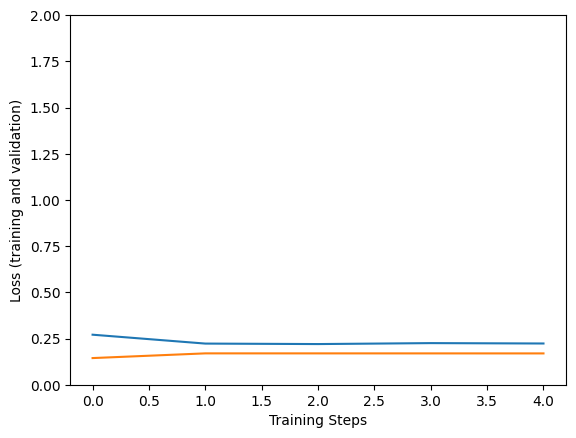

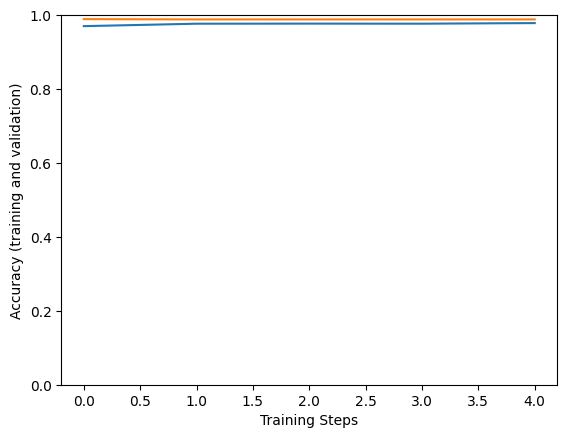

In [ ]:
#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf_keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

/usr/local/lib/python3.11/dist-packages/tf_keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'keras.src.regularizers.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [ ]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf_keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:13<00:00,  9.03it/s]


In [ ]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


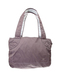

In [ ]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [ ]:
#hide-output
styles = pd.read_csv('/content/dataset4/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
styles.to_csv('/content/dataset4/styles.csv', index=False)

In [ ]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:21, 235.82it/s]


In [ ]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [ ]:
#hide
file_path = '/content/drive/MyDrive/ImgSim/'

In [ ]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

In [ ]:
#hide
from PIL import Image
import matplotlib.image as mpimg

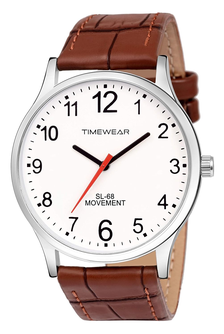

In [ ]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

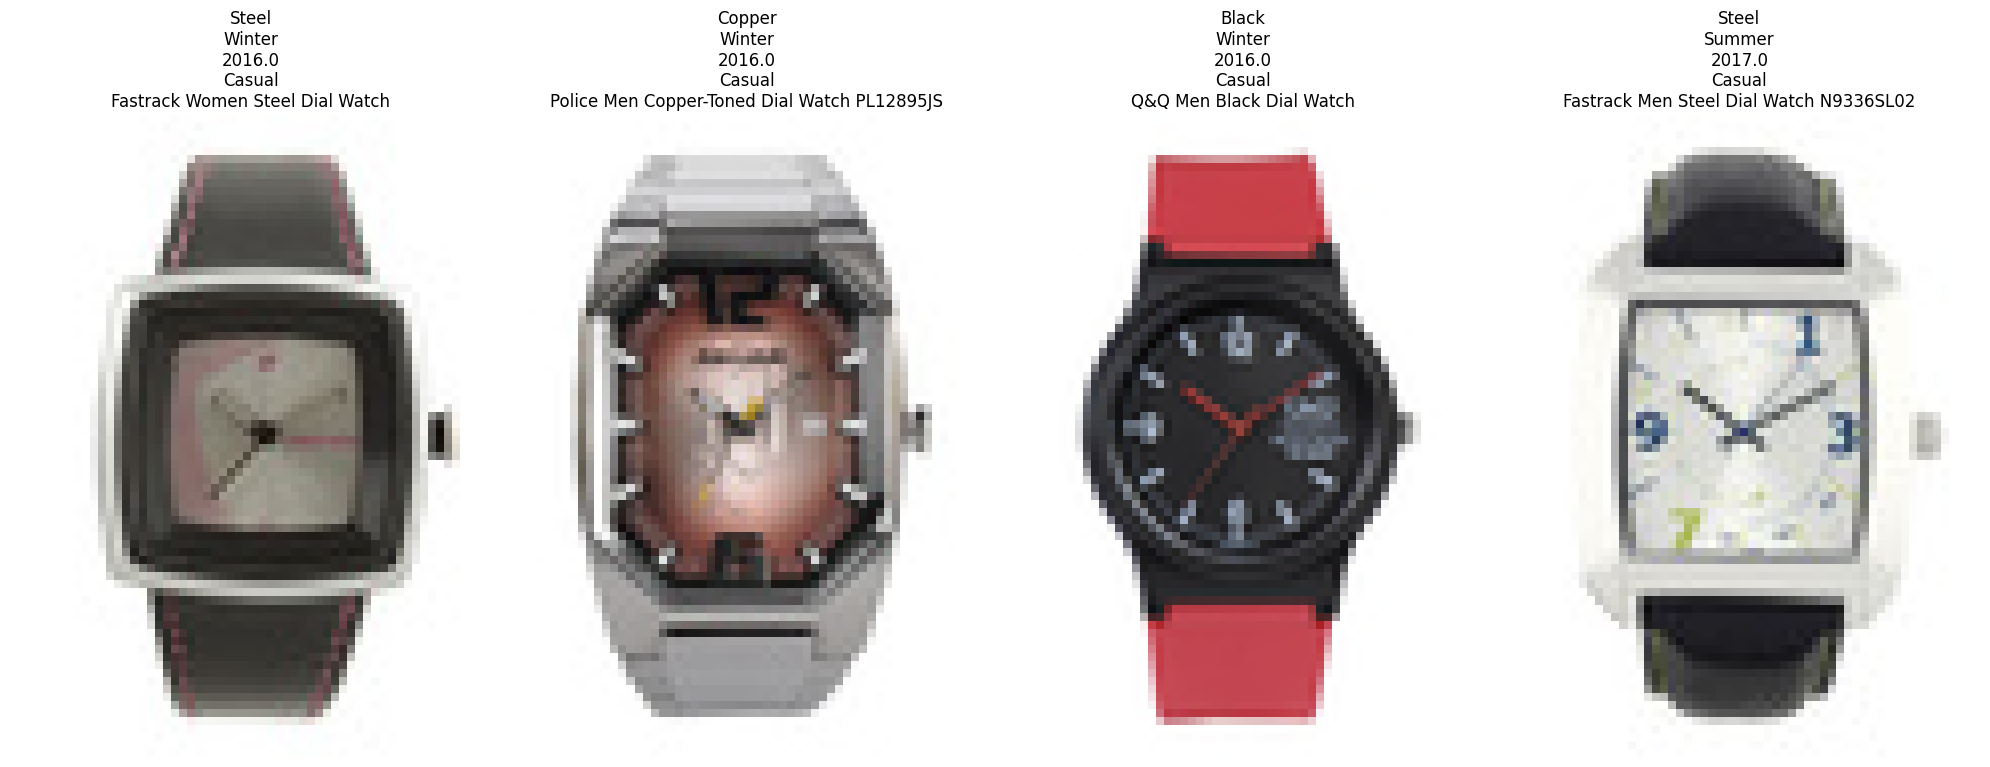

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()